# Examen ISBS1 -- Traitement du signal

**Tous documents autorisés** <br>
Durée :  deux heures


Avant toute chose, vous chargerez les modules utiles, comme lors des séances de cours/td, en appelant le programme `nbinit.ipy` qui se charge de charger les modules utiles. 

In [20]:
%run nbinit.ipy

... Configuring matplotlib formats
... Configuring matplotlib with inline figures
... Importing numpy as np, scipy as sp, pyplot as plt, scipy.stats as stats
   ... scipy.signal as sig
... Importing widgets, display, HTML, Image, Javascript
... Loading customized Javascript for LaTeX typesetting
Running js_addon
interactive_init_cells was already defined -- reloading it


... Some LaTeX definitions


... Defining figures captions 


... Loading customized Javascript for interactive solutions (show/hide)
Overriding run-range javascript function


In [53]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
import seaborn as sns   # à commenter si seaborn n'est pas installé
# (utilisé ici pour le corrigé)
sns.mpl.rc("figure", figsize=(8,5))   #idem 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


## 0 - Consignes : 

**1. Questions de cours**:

   - L'épreuve comprend 10 questions de cours, que vous retrouverez sur [icampus](https://icampus.esiee.fr/mod/quiz/view.php?id=4687) -- 10 questions, nombre de tentatives illimitées, dernière tentative retenue.

**2. Questions comprenant une mise en oeuvre numérique** :
 - Editer le nom du notebook, ci-dessus, en `votre_nom`
 - vous devez faire les calculs numériques dans ce notebok. En fin d'épreuve, vous vous connecterez sur icampus "[remise de devoir](https://icampus.esiee.fr/mod/assign/view.php?id=4713)" et transférerez ce notebook. 
 - vous pouvez ajouter une copie de commentaires, si vous le jugez utile
 

## 1 - Conception d'un filtre réjecteur et application au filtrage d'un Electrocardioramme (ECG)

Vous chargerez les données de mesures d'un ECG par 
```
ecg=np.load('ecg.npy')
```
Il s'agit de données **réelles**. 

- La fréquence d'échantillonnage utilisée est de $f_s=1000$ Hz. 

Les mesures sont entâchées par un fort "bruit" constitué par une interférence électrique à 50Hz. Une partie de votre travail va consister à vous débarasser de cette interérence. 

### 1.1 Représentation du signal

Avant cela on va regarder comment sont faites les données. Faites attention au fait que l'on a *beaucoup de points*. Si vous tracez brutalement le signal, cela risque d'encombrer la mémoire et de prendre pas mal de temps. Je vous suggère donc de ne tracer qu'une portion du signal (par exemple 3000 points, de 0:3000)

1 -  Donner le nombre de points composant le signal ecg

In [54]:
ecg=np.load('ecg.npy')
# cellule de code pour faire des calculs si nécessaire
# ....
# --> insérer la réponse ici
N=np.size(ecg)
print("N=",N)

N= 176220


2 -  Quelle durée représente 3000 échantillons ? Quelle durée représente la totalité des échantillons disponible ?

In [55]:
# cellule de code pour faire des calculs si nécessaire

# --> insérer les réponses ici
duree_3000= 3000/1000 # =3s!
duree_totale= N/1000
print("durée totale : {} s".format(duree_totale))

durée totale : 176.22 s


3 - Tracer 3000 points du signal temporel, mettre un titre "ECG - représentation temporelle", un label pour l'axe des abscisses, et *graduer correctement les abscisses en secondes*.

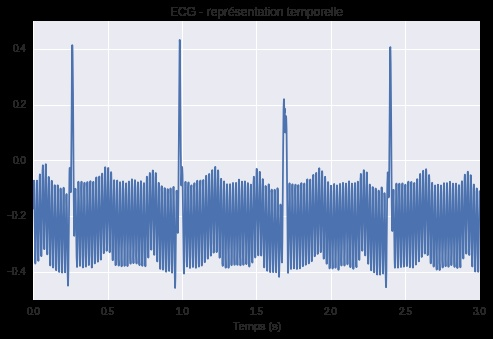

In [56]:
fs=1000
t=np.arange(0,3000)/fs # Axe temporel - 1/fs est la période d'échantillonnage
plt.plot(t,ecg[:3000])
plt.title("ECG - représentation temporelle")
_=plt.xlabel("Temps (s)")


4 - On veut maintenant examiner le signal en fréquence. Calculer et tracer la transformée de Fourier prise sur 4096 points (on aime bien les puissances de deux),  mettre un titre "ECG - représentation fréquentielle", un label pour l'axe des abscisses, et *graduer correctement les abscisses en fréquences* (on rappelle que la fréquence d'échantillonnage est $f_s=1000$ Hz. Vous pourrez éventuellement zoomer la représentation -- par exemple sur [0, 250Hz], en utilisant la commande `plt.xlim`.  

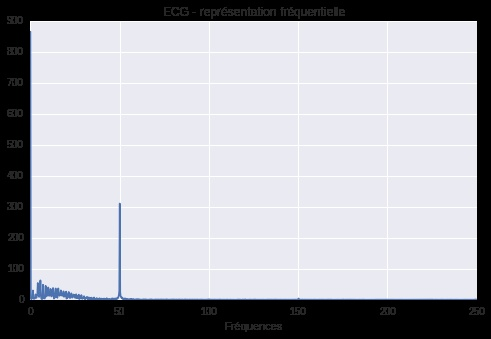

In [57]:
# cellule de code pour faire les calculs et lancer la représentation
# ....

M=4096  #M=N for computing on all samples
ecgf=fft(ecg[0:M]) # calcul de la TF

fs=1000
f=np.linspace(0,fs,M)  # axe des fréquences
plt.plot(f,np.abs(ecgf))
plt.xlabel('Fréquences')
plt.title('ECG - représentation fréquentielle')
_=plt.xlim([0,250])
plt.grid('on')

--> Commenter dans la cellule ci-dessous, ou sur une feuille de papier à part, sur les caractéristiques marquantes que vous observez sur cette représentation. 


> On observe une raie très importante à 50 Hz. C'est bien entendu l'interférence électrique qui a pollué notre ECG. On note également que la TF est très basse fréquence, en gros nulle après 70 ou 100 Hz. Enfin, si on zoome sur la partie basse-fréquence, entre 0 et 35Hz, on voit apparaître une série de pics qui sont indicateurs d'un signal périodique. Et c'est un peu normal car un ECG a tendance a être périodique... En gros on compte 14 pics sur 20 Hz, ce qui représente une fréquence fondamentale de 20/14 Hz, soit ~ 85 battements par minute. 

Au vu de la représentation fréquentielle, serait il possible de sous-échantillonner ce signal ? Dans l'affirmative, quelle fréquence suggéreriez vous ?


--> Répondre dans la cellule ci-dessous, ou sur une feuille de papier à part, sur la possibilité de sous-échantillonnage. 

> Comme la  TF est très basse fréquence, en gros nulle après  100 Hz, il serait donc possible d'échantillonner à 200Hz, ce qui ne serait pas plus mal : on gagnerait un facteur 5 sur le nombre d'échantillons. 

### 1.2 Filtrage

Nous avons vu que pour retirer une interférence périodique polluant un signal à variations lentes, il suffit de calculer une moyenne glissante, locale,  sur une durée d'une période. C'est cette idée que vous allez mettre en oeuvre ici. 

1 - Quel est le nombre de points $L$ par période du signal parasite ? Définissez la réponse impulsionnelle d'un filtre moyenneur sur cette durée. Tracez la fonction de transfert, à nouveau sur $M=4096$ points et en utilisant une échelle correcte pour l'axe des abscisses. Vous pouvez avoir intérêt à zoomer la représentation -- par exemple sur [0, 250Hz], en utilisant la commande `plt.xlim`.  

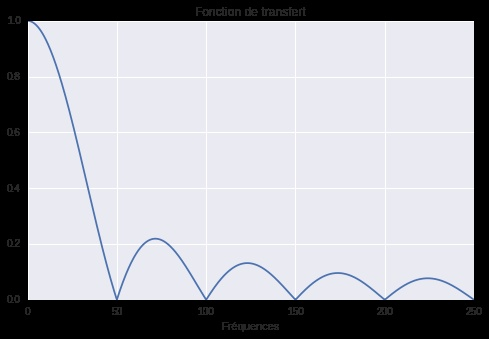

In [58]:
L=1000/50  # nb de points par période
# définition de h
h=1/L*np.ones(L)

# calcul de la fonction de transfert
H=fft(h,M) #avec M=4096

# tracé..
fs=1000
f=np.linspace(0,fs,M)  # axe des fréquences
plt.plot(f,np.abs(H))
plt.xlabel('Fréquences')
plt.title('Fonction de transfert')
_=plt.xlim([0,250])
plt.grid('on')


2 - Filtrez la totalité du signal ecg par ce filtre, puis affichez 1000 ou 2000 points du résultat que vous comparerez au signal initial (vous pouvez faire des subplots ou tracer sur le même graphique; il pourrait être opportun d'ajouter une légende -- commande `plt.legend()` et définir des labels). 

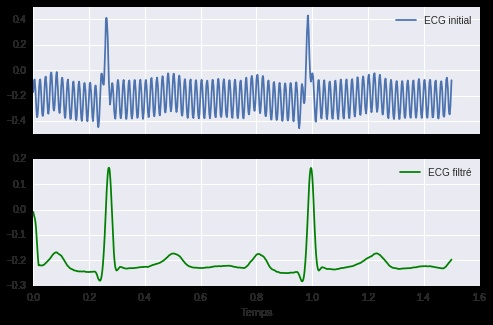

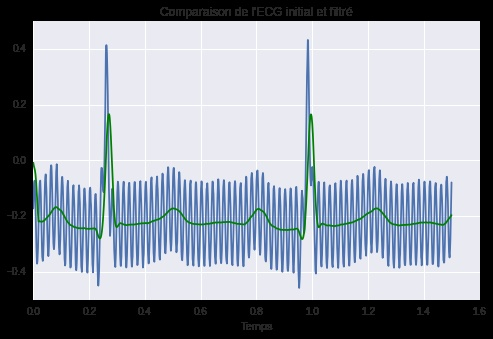

In [59]:
# filtrage par h
ecg_filtered = sig.lfilter(h, [1], ecg)

# tracé
n=np.arange(0,1500)
t=n/fs

f,ax=plt.subplots(nrows=2,ncols=1,sharex=True)
ax[0].plot(t, ecg[n], label="ECG initial")
ax[1].plot(t, ecg_filtered[n], color='green', label="ECG filtré")
ax[1].set_xlabel("Temps")
for k in (0,1): ax[k].legend()

    
# les deux sur le même graphique
plt.figure()
plt.plot(t, ecg[n], label="ECG initial")
plt.plot(t, ecg_filtered[n], color='green', label="ECG filtré")
plt.title("Comparaison de l'ECG initial et filtré")
plt.xlabel("Temps")


3 - Normalement vous devriez voir apparaître un retard entre les deux signaux. Expliquez d'où peut venir ce décalage. 

> --> D'où vient le décalage temporel ? 
Tout simplement du retard de traitement apporté par le filtre. Ce retard est simplement la longueur du filtre/2


Recalez les signaux en introduisant un retard adéquat [attention, ce doit être un nombre entier.Forcer éventuellement le type par un cast `int()`)  et tracez à nouveau la comparaison des signaux avant et après filtrage. 

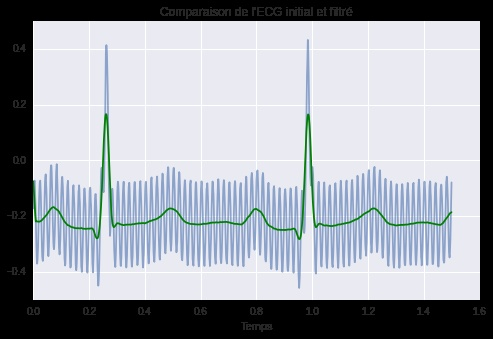

In [60]:
# if suffit d'introduire un délai de L/2 (en partie entière)
# les deux sur le même graphique
plt.figure()
plt.plot(t, ecg[n], label="ECG initial", alpha=0.6)
plt.plot(t, ecg_filtered[n+int(L/2)], color='green', label="ECG filtré")
plt.title("Comparaison de l'ECG initial et filtré")
plt.xlabel("Temps")


## 2. Une question subsidiaire

On considère maintenant un filtre à réponse impulsionnelle infinie possédant les coefficients suivants :

In [61]:
a= array([  1.        ,  -5.48487936,  12.79990334, -16.24900038,
        11.83119266,  -4.68619948,   0.78979292])
a

array([  1.        ,  -5.48487936,  12.79990334, -16.24900038,
        11.83119266,  -4.68619948,   0.78979292])

In [62]:
b = array([  0.88870296,  -5.07375285,  12.3217415 , -16.27257352,
        12.3217415 ,  -5.07375285,   0.88870296])
b

array([  0.88870296,  -5.07375285,  12.3217415 , -16.27257352,
        12.3217415 ,  -5.07375285,   0.88870296])

### 2.1 -  Tracé de la réponse impulsionnelle

Calculer la réponse impulsionnelle (sur 200 points), en appliquant la définition..
Tracez le résultat, en utilisant un diagramme en batons (fonction `plt.stem`). 

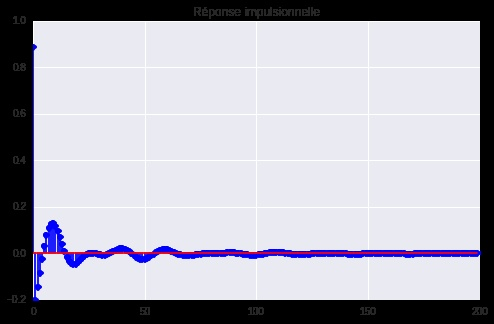

In [63]:
# calcul de la RI
#
d=np.zeros(200); d[0]=1
h=sig.lfilter(b,a,d)
# tracé
plt.stem(h)
plt.title("Réponse impulsionnelle")


### 2.2 -  Tracé de la fonction de transfert

Calculez puis tracez la fonction de transfert, comme toujours **avec un axe des abscisses gradué correctement **. 

In [64]:
# calcul de la fonction de transfert 
H=fft(h,4096)
#

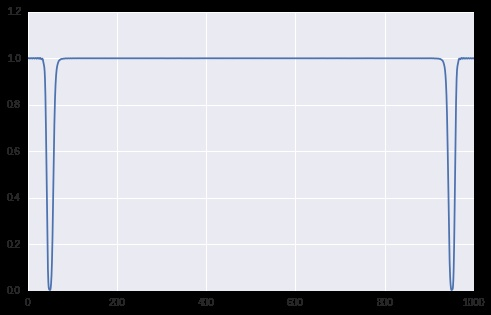

In [65]:
# tracé..
f=np.linspace(0,1,4096)*fs
plt.plot(f,abs(H))
